Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then step by step run the code blocks. If you pass all code blocks, remember to **Save** and **Submit** your notebook to the system.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Nguyễn Duy Đạt"

---

# MẠNG CONVOLUTIONAL NEURAL NETWORK (CNN)

Bài tập này, ta sẽ tiến hành cài đặt một trong những mạng `CNN` đầu tiên là LeNet. Kiến trúc của mạng LeNet được tóm tắt như sau:

![](LeNet.png)

Trong hình trên kiến trúc của mô hình được tóm tắt như sau:

**Lớp input**: chứa ảnh đầu vào 
- Kích thước ảnh của tập MNIST là `28x28`. Do ảnh này là ảnh mức xám (không có màu) nên độ sâu bằng 1.

**Lớp convolution C1**: lớp biến đổi đặc trưng đầu tiên, sử dụng phép biến đổi convolution kết hợp với hàm kích hoạt. 

- Phiên bản năm 1998 Yann Lecun sử dụng `6 filter` kích thước `3x3`, hàm kích hoạt `sigmoid`.

**Lớp pooling** hay subsampling S2: lớp làm giảm kích thước chiều không gian (chiều ngang và dọc). 
- Phiên bản năm 1998 sử dụng filter `AveragePooling` với kích thước à `2x2`.

**Lớp convolution C3**: tương tự C1 nhưng số filter nhiều hơn *nhằm tạo ra các **đặc trưng cấp cao** kết hợp từ các đặc trưng cấp thấp trước đó*. 
- Lớp này sử dụng `16 filter` kích thước `3x3` với hàm kích hoạt `sigmoid`.

**Lớp convolution S4**: tương tự như lớp S2. 
- Ta sử dụng filter `AveragePooling`, kích thước filter là `2x2`.

**Lớp fully connected (kết nối đầu đủ) F5**: thực hiện phép nhân tuyến tính kết hợp với hàm kích hoạt. Các lớp F5 trở đi thực hiện chức năng phân loại (classify) đặc trưng đã rút trích từ các bước trước đó.
- Phiên bản này sử dụng hàm `sigmoid`. Số neuron output của lớp này là **120 neuron**.
- Lưu ý quan trọng: trước lớp F5, ta sẽ có "bước đệm" là `Flatten` để biến đặc trưng **từ dạng tensor thành dạng vector**.

**Lớp fully connected F6**: tương tự lớp F5.
- Số neuron output của lớp này là **84 neuron**, hàm kích hoạt `sigmoid`.

**Lớp output**: Tương tự như F5.
- Số neuron output của lớp này là **10 neuron**, sử dụng hàm `softmax` để đưa đặc trưng về không gian xác suất của các lớp đối tượng cần phân loại.

Bắt đầu tiến hành cài đặt thôi!

## 1. Chuẩn bị dữ liệu huấn luyện
Đầu tiên, ta sẽ sử dụng tập dữ liệu MNIST cho bài tập này. Trong `keras.datasets` có rất nhiều dữ liệu được đóng gói và chuẩn bị sẵn như `MNIST`, `CIFAR`, `Fashion MNIST`. Trong bài tập này, ta sẽ sử dụng tập dữ liệu `MNIST`:

In [2]:
from keras.datasets import mnist
import numpy as np
import tensorflow as tf


def fix_random_seed():
    np.random.seed(1)
    tf.random.set_seed(1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("Thông tin kích thước các biến trên: ")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Thông tin kích thước các biến trên: 
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [3]:
print('Ý nghĩa kích thước các biến trên: ')
print('Số mẫu train: {} mẫu'.format(x_train.shape[0]))
print('Số mẫu test: {} mẫu'.format(x_test.shape[0]))
print('Kích thước ảnh đầu vào: ', x_train.shape[1:])

Ý nghĩa kích thước các biến trên: 
Số mẫu train: 60000 mẫu
Số mẫu test: 10000 mẫu
Kích thước ảnh đầu vào:  (28, 28)


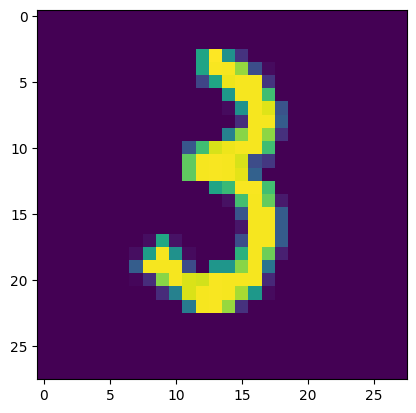

Nhãn (label) của ground-truth:  3


In [4]:
# Code block này hiển thị một mẫu dữ liệu train. 
# Đây là việc NÊN LÀM khi bắt đầu với bất kỳ dữ liệu nào
# Ở đây ta sẽ load mẫu dữ liệu thứ 1234. Các bạn có thể thay đổi giá trị này tùy ý
import matplotlib.pyplot as plt

sample_id = 1234
plt.imshow(x_train[sample_id])
plt.show()
print('Nhãn (label) của ground-truth: ', y_train[sample_id])

## 2. Tiền xử lý dữ liệu
Việc chuẩn hóa dữ liệu bao gồm hai nhóm công việc chính:
* Đối với output `y`: chuyển đổi **từ dạng nhãn (label) sang dạng one-hot encoding**.
* Đối với input `x`: chuẩn hóa các giá trị mức sáng **từ [0-255] về đoạn [0-1]**. Bước này cải tiến tốc độ huấn luyện một cách đáng kể.

In [5]:
# Hàm này được sử dụng để chuyển đổi output từ dạng 
# nhãn sang dạng one-hot vector
def onehot(y):
    oh = np.zeros((y.shape[0], 10))
    for i in range(y.shape[0]):
        oh[i, int(y[i])]=1
    return oh

In [6]:
from sklearn import preprocessing
import numpy as np

# Chuyển đổi từ dạng label sang dạng one-hot encoding
y_train_oh = onehot(y_train)
y_train_oh.shape

y_test_oh = onehot(y_test)
y_test_oh.shape

# Chuẩn hóa ảnh đầu vào về [0-1]
x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

In [7]:
# Các bạn có thể xem dữ liệu trước và sau khi tiền xử lý
# Các bạn có thể thay đổi sample_id bằng số tùy ý
sample_id = 4321

print("`y` TRƯỚC khi biến đổi: ", y_train[sample_id])
print("`y` SAU khi biến đổi: ", y_train_oh[sample_id])

`y` TRƯỚC khi biến đổi:  0
`y` SAU khi biến đổi:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
print("`x` TRƯỚC khi biến đổi: ", x_train[sample_id])
print("`x` SAU khi biến đổi: ", x_train_norm[sample_id])

`x` TRƯỚC khi biến đổi:  [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   48 191 255 203   7   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   7  57
  172 252 247 196  43   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 104 252
  252 252  50   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 201 253 252
  252 202  51   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  

## 3. Cài đặt mạng CNN với kiến trúc LeNet

Import các thư viện Keras phục vụ cho việc cài đặt mô hình:

Đầu tiên, ta sẽ import các thư viện, module, hàm của `Keras`:
- `Input`: để nhận dữ liệu đầu vào cho mô hình
- `Conv2D`: biến đổi Convolution với activation
- `AveragePooling2D`: giảm kích thước đặc trưng
- `Dense`: hay còn gọi là lớp Fully Connected (Lớp kết nối đầy đủ), một thành phần quan trọng của các mô hình dựa trên mạng Neural Network.
- `Model`: đây là lớp đối tượng mô hình được sử dụng để đóng gói lớp đầu vào, đầu ra, sau đó huấn luyện với phương thức `fit` và dự đoán kết quả với `predict`.
- `load_model`: hàm sử dụng để load mô hình lên từ file

In [9]:
from keras.layers import Input, Dense, Conv2D, AveragePooling2D, Flatten
from keras.models import load_model, Model
import keras

In [10]:
class LeNetCNN:
  # constructor
  def __init__(self):
    self.model = None

  # Định nghĩa kiến trúc của mô hình
  def build(self, input_dim):
    input = Input(shape = input_dim) # input
    
    # Bước rút trích đặc trưng
    C1 = Conv2D(6, (3, 3), padding='same', activation='sigmoid')(input)
    S2 = AveragePooling2D(pool_size=(2, 2), padding="same")(C1)
    C3 = Conv2D(16, (3, 3), padding='same', activation='sigmoid')(S2)
    S4 = AveragePooling2D(pool_size=(2, 2), padding="same")(C3)
    # Bước trung gian chuyển từ tensor sang vector
    flat = Flatten()(S4)
    # Bước phân loại đặc trưng bước trước
    F5 = Dense(120, activation='sigmoid', use_bias=True)(flat)
    F6 = Dense(84, activation='sigmoid', use_bias=True)(F5)
    output = Dense(10, activation='softmax', use_bias=True)(F6) # y~ output
    
    self.model = Model(input, output)

  # Huấn luyện mô hình
  def train(self, x_train, y_train): # x_train chinh la X, y_train chinh la ground-truth
    adam = keras.optimizers.Adam(learning_rate=0.01)
    self.model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
    self.model.fit(x_train, y_train, epochs = 10, batch_size = 128)

  # Load mô hình từ file
  def load(self, model_file):
    self.model = load_model(model_file)

  # Lưu mô hình hiện tại xuống file
  def save(self, model_file):
    self.model.save(model_file)

  # Tóm tắt kiến trúc mạng
  def summary(self):
    self.model.summary()

  # Thử nghiệm mô hình với dữ liệu ảnh đầu vào
  def predict(self, x_test):
    return self.model.predict(x_test)
  
  # Đánh giá trên tập dữ liệu test
  def predict_and_eval(self, x_test_norm, y_test):
    # Predict trên tập dữ liệu test
    test_pred = self.model.predict(x_test_norm)

    # Đánh giá độ chính xác trên toàn bộ tập test
    accuracy = tf.keras.metrics.Accuracy()
    labels_pred = [np.argmax(i) for i in test_pred]
    accuracy.update_state(labels_pred, y_test)
    print('Độ chính xác của phiên bản hiện tại: {}'.format(accuracy.result().numpy()*100))


In [11]:
# Khởi tạo random seed để cố định kết quả huấn luyện cho tất cả mọi người
fix_random_seed()

# Khởi tạo đối tượng mạng CNN kiến trúc LeNet
lenet = LeNetCNN()
# Xây dựng kiến trúc mô hình với ảnh đầu vào kích thước 28x28x1
lenet.build((28, 28, 1))
lenet.summary()
lenet.train(x_train_norm, y_train_oh)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         60        
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        880       
                                                                 
 average_pooling2d_1 (Averag  (None, 7, 7, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 784)               0     

Với kiến trúc mạng ở trên, hãy quan sát và xem có thông tin nào bạn chưa thực sự hiểu rõ không?

Các thông tin cần nắm vững:
- Tên lớp
- Kích thước lớp
- Số lượng tham số

Thảo luận với bạn bè / thầy cô khi có chỗ nào chưa rõ trong các tham số trên.

313/313 [==============================] - 1s 3ms/step


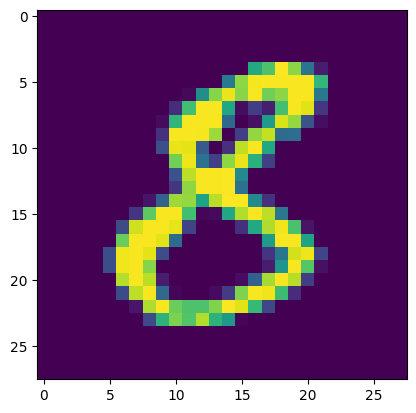

Nhãn dự đoán:  8
Nhãn ground-truth:  8


In [14]:
# Predict trên tập dữ liệu test
pred = lenet.predict(x_test_norm)
test_index = 1234
plt.imshow(x_test[test_index])
plt.show()
print('Nhãn dự đoán: ', np.argmax(pred[test_index]))
print('Nhãn ground-truth: ', y_test[test_index])

In [13]:
# Đánh giá hiệu quả của hệ thống trên tập test
lenet.predict_and_eval(x_test_norm, y_test)

313/313 [==============================] - 1s 3ms/step
Độ chính xác của phiên bản hiện tại: 98.47999811172485


## 4. Thử nghiệm với một số biến thể

### 4.1 Biến thể Alpha - Thay activation `sigmoid` bằng `relu`

In [16]:
class AlphaCNN(LeNetCNN):
  # Define structure of the CNN
  def build(self, input_dim):
    input = None
    output = None
    # YOUR CODE HERE
    input = Input(shape = input_dim) # input
    
    # Bước rút trích đặc trưng
    C1 = Conv2D(6, (3, 3), padding='same', activation='relu')(input)
    S2 = AveragePooling2D(pool_size=(2, 2), padding="same")(C1)
    C3 = Conv2D(16, (3, 3), padding='same', activation='relu')(S2)
    S4 = AveragePooling2D(pool_size=(2, 2), padding="same")(C3)
    # Bước trung gian chuyển từ tensor sang vector
    flat = Flatten()(S4)
    # Bước phân loại đặc trưng bước trước
    F5 = Dense(120, activation='relu', use_bias=True)(flat)
    F6 = Dense(84, activation='relu', use_bias=True)(F5)
    output = Dense(10, activation='softmax', use_bias=True)(F6) # y~ output
    self.model = Model(input, output)


In [17]:
# Khởi tạo random seed để cố định kết quả huấn luyện cho tất cả mọi người
fix_random_seed()
# Khởi tạo đối tượng mạng CNN kiến trúc Alpha
alpha = AlphaCNN()
# Xây dựng kiến trúc mô hình với ảnh đầu vào kích thước 28x28x1
alpha.build((28, 28, 1))
alpha.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 6)         60        
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        880       
                                                                 
 average_pooling2d_3 (Averag  (None, 7, 7, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 784)               0   

In [18]:
# Kiểm tra kiến trúc Alpha

# Kiểm tra số layer không đổi
assert len(alpha.model.layers) == 9
# Kiểm tra một số lớp trong kiến trúc mạng Alpha
assert "keras.engine.input_layer.InputLayer" in str(type(alpha.model.layers[0]))
assert "keras.layers.convolutional.conv2d.Conv2D" in str(type(alpha.model.layers[1]))
assert "keras.layers.pooling.average_pooling2d.AveragePooling2D" in str(type(alpha.model.layers[2]))
assert "class 'keras.layers.core.dense.Dense" in str(type(alpha.model.layers[6]))
# Kiểm tra hàm activation của lớp convolution
assert alpha.model.layers[1].activation(1.0).numpy() == 1.0
assert alpha.model.layers[1].activation(-1.0).numpy() == 0.0

In [ ]:
# Kiểm tra với bộ test ẩn

In [19]:
# Sau khi đã đảm bảo rằng kiến trúc của bạn đã ổn. Chờ gì nữa, train thôi!
alpha.train(x_train_norm, y_train_oh)

Epoch 1/10
469/469 [==============================] - 7s 15ms/step - loss: 0.1753 - accuracy: 0.9439
Epoch 2/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0607 - accuracy: 0.9815
Epoch 3/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0464 - accuracy: 0.9857
Epoch 4/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0400 - accuracy: 0.9881
Epoch 5/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0337 - accuracy: 0.9897
Epoch 6/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0281 - accuracy: 0.9912
Epoch 7/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0303 - accuracy: 0.9909
Epoch 8/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0284 - accuracy: 0.9915
Epoch 9/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0282 - accuracy: 0.9916
Epoch 10/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0261 - accura

In [20]:
# Đánh giá hiệu quả của mô hình trên tập test
alpha.predict_and_eval(x_test_norm, y_test)

313/313 [==============================] - 1s 3ms/step
Độ chính xác của phiên bản hiện tại: 98.50999712944031


Theo bạn giữa phiên bản LeNet và Alpha, bạn thấy ĐỘ CHÍNH XÁC trên tập test của hai mô hình này có sự chênh lệch đáng kể hay không?

In [22]:
options = ['Không có ý kiến', 'LeNet tốt hơn Alpha', 'LeNet tệ hơn Alpha', 'LeNet ngang ngửa Alpha (chênh không quá 1%)']
your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
# YOUR CODE HERE
your_choice = 0

print("Theo mình thì: ", options[your_choice])

Theo mình thì:  Không có ý kiến


In [ ]:
# Kiểm tra với bộ test ẩn

Quan sát độ chính xác trên tập train của quá trình huấn luyện, theo bạn mô hình nào cho **tốc độ hội tụ** (*thể hiện tốc độ cải thiện độ chính xác qua từng epoch*) nhanh hơn?

In [23]:
options = ['Không có ý kiến', 'LeNet hội tụ nhanh hơn Alpha', 'LeNet hội tụ chậm hơn Alpha', 
           'LeNet hội tụ nhanh ngang ngửa Alpha (tại epoch huấn luyện thứ 1 , chênh lệch acc không quá 5%']
your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
# YOUR CODE HERE
your_choice = 1

print("Theo mình thì: ", options[your_choice])

Theo mình thì:  LeNet hội tụ nhanh hơn Alpha


In [ ]:
# Kiểm tra với bộ test ẩn

### 4.2. Biến thể Beta - Thay AveragePooling bằng MaxPooling
Lưu ý rằng, biến thể `Beta` được phát triển tiếp từ biến thể `Alpha`, do đó cấu hình liên quan đến hàm activation cũng sử dụng `ReLU`

In [27]:
from keras.layers import MaxPooling2D
class BetaCNN(LeNetCNN):
  # Define structure of the CNN
  def build(self, input_dim):
    input = None
    output = None
    # YOUR CODE HERE
    input = Input(shape = input_dim) # input
    
    # Bước rút trích đặc trưng
    C1 = Conv2D(6, (3, 3), padding='same', activation='relu')(input)
    S2 = MaxPooling2D(pool_size=(2, 2), padding="same")(C1)
    C3 = Conv2D(16, (3, 3), padding='same', activation='relu')(S2)
    S4 = MaxPooling2D(pool_size=(2, 2), padding="same")(C3)
    # Bước trung gian chuyển từ tensor sang vector
    flat = Flatten()(S4)
    # Bước phân loại đặc trưng bước trước
    F5 = Dense(120, activation='relu', use_bias=True)(flat)
    F6 = Dense(84, activation='relu', use_bias=True)(F5)
    output = Dense(10, activation='softmax', use_bias=True)(F6) # y~ output
    self.model = Model(input, output)


In [28]:
# Khởi tạo random seed để cố định kết quả huấn luyện cho tất cả mọi người
fix_random_seed()

# Khởi tạo đối tượng mạng CNN kiến trúc Beta
beta = BetaCNN()
# Xây dựng kiến trúc mô hình với ảnh đầu vào kích thước 28x28x1
beta.build((28, 28, 1))
beta.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 6)         60        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 16)        880       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 784)               0   

In [29]:
# Kiểm tra kiến trúc Beta

# Kiểm tra số layer không đổi
assert len(beta.model.layers) == 9
# Kiểm tra một số lớp trong kiến trúc mạng
assert "keras.engine.input_layer.InputLayer" in str(type(beta.model.layers[0]))
assert "keras.layers.convolutional.conv2d.Conv2D" in str(type(beta.model.layers[1]))
assert "keras.layers.pooling.max_pooling2d.MaxPooling2D" in str(type(beta.model.layers[2]))
assert "keras.layers.core.dense.Dense" in str(type(beta.model.layers[6]))
# Kiểm tra hàm activation của lớp convolution
assert beta.model.layers[1].activation(1.0).numpy() == 1.0
assert beta.model.layers[1].activation(-1.0).numpy() == 0.0

In [ ]:
# Kiểm tra với bộ test ẩn

In [30]:
# Train đi, chờ chi!
beta.train(x_train_norm, y_train_oh)

Epoch 1/10
469/469 [==============================] - 7s 14ms/step - loss: 0.1638 - accuracy: 0.9465
Epoch 2/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0606 - accuracy: 0.9817
Epoch 3/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0496 - accuracy: 0.9854
Epoch 4/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0427 - accuracy: 0.9871
Epoch 5/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0391 - accuracy: 0.9890
Epoch 6/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0373 - accuracy: 0.9893
Epoch 7/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0366 - accuracy: 0.9898
Epoch 8/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0342 - accuracy: 0.9899
Epoch 9/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0320 - accuracy: 0.9910
Epoch 10/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0314 - accura

In [31]:
# Đánh giá trên tập dữ liệu test
beta.predict_and_eval(x_test_norm, y_test)

313/313 [==============================] - 1s 4ms/step
Độ chính xác của phiên bản hiện tại: 98.36000204086304


Theo bạn giữa phiên bản Alpha và Beta, bạn thấy kết quả có sự thay đổi đáng kể hay không?

In [54]:
options = ['Không có ý kiến', 'Alpha tốt hơn Beta', 'Alpha tệ hơn Beta', 'Alpha ngang ngửa Beta (chênh không quá 1%)']

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
# YOUR CODE HERE
your_choice = 1

print("Theo tôi thì: ", options[your_choice])

Theo tôi thì:  Alpha tốt hơn Beta


In [ ]:
# Kiểm tra với bộ test ẩn

Như vậy, đến bước này, bạn đã cài đặt xong mô hình LeNet theo hướng hiện đại, hay còn gọi là LeNet phiên bản 2020.

Không dừng lại ở đó, ta sẽ thử với một số biến thể táo bạo hơn.

### 4.3 Biến thể Gamma - Bỏ hết hàm activation trong biến thể Beta
Biến thể Gamma ra đời vì sự nghi ngờ rằng, **hàm activation không thực sự hữu ích** trong kiến trúc mạng CNN. Bạn hãy thử cài đặt, đánh giá xem giả thuyết này có đúng không?

In [33]:
class GammaCNN(LeNetCNN):
  # Define structure of the CNN
  def build(self, input_dim):
    input = None
    output = None
    # YOUR CODE HERE
    input = Input(shape = input_dim) # input
    
    # Bước rút trích đặc trưng
    C1 = Conv2D(6, (3, 3), padding='same')(input)
    S2 = MaxPooling2D(pool_size=(2, 2), padding="same")(C1)
    C3 = Conv2D(16, (3, 3), padding='same')(S2)
    S4 = MaxPooling2D(pool_size=(2, 2), padding="same")(C3)
    # Bước trung gian chuyển từ tensor sang vector
    flat = Flatten()(S4)
    # Bước phân loại đặc trưng bước trước
    F5 = Dense(120, use_bias=True)(flat)
    F6 = Dense(84, use_bias=True)(F5)
    output = Dense(10, use_bias=True)(F6) # y~ output

    self.model = Model(input, output)


In [34]:
# Khởi tạo random seed để cố định kết quả huấn luyện cho tất cả mọi người
fix_random_seed()

# Khởi tạo đối tượng mạng CNN kiến trúc Gamma
gamma = GammaCNN()
# Xây dựng kiến trúc mô hình với ảnh đầu vào kích thước 28x28x1
gamma.build((28, 28, 1))
gamma.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 6)         60        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 16)        880       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 784)               0   

In [35]:
# Kiểm tra kiến trúc Gamma

# Kiểm tra số layer không đổi
assert len(gamma.model.layers) == 9
# Kiểm tra một số lớp trong kiến trúc mạng 
assert "keras.engine.input_layer.InputLayer" in str(type(gamma.model.layers[0]))
assert "keras.layers.convolutional.conv2d.Conv2D" in str(type(gamma.model.layers[1]))
assert "keras.layers.pooling.max_pooling2d.MaxPooling2D" in str(type(gamma.model.layers[2]))
assert "keras.layers.core.dense.Dense" in str(type(gamma.model.layers[6]))
# Kiểm tra hàm activation của lớp convolution
assert gamma.model.layers[1].activation(1.0) == 1.0
assert gamma.model.layers[1].activation(-1.0) == -1.0

In [ ]:
# Kiểm tra với bộ test ẩn

In [36]:
# Train train train!
gamma.train(x_train_norm, y_train_oh)

Epoch 1/10
469/469 [==============================] - 10s 21ms/step - loss: 6.5987 - accuracy: 0.1052
Epoch 2/10
469/469 [==============================] - 10s 21ms/step - loss: 6.4806 - accuracy: 0.1044
Epoch 3/10
469/469 [==============================] - 10s 21ms/step - loss: 6.4806 - accuracy: 0.1044
Epoch 4/10
469/469 [==============================] - 10s 20ms/step - loss: 6.4806 - accuracy: 0.1044
Epoch 5/10
469/469 [==============================] - 10s 21ms/step - loss: 6.4805 - accuracy: 0.1044
Epoch 6/10
469/469 [==============================] - 10s 21ms/step - loss: 6.4806 - accuracy: 0.1044
Epoch 7/10
469/469 [==============================] - 9s 20ms/step - loss: 6.4806 - accuracy: 0.1044
Epoch 8/10
469/469 [==============================] - 10s 21ms/step - loss: 6.4806 - accuracy: 0.1044
Epoch 9/10
469/469 [==============================] - 8s 16ms/step - loss: 6.4805 - accuracy: 0.1044
Epoch 10/10
469/469 [==============================] - 7s 14ms/step - loss: 6.4806 -

In [37]:
# Đánh giá trên tập dữ liệu test
gamma.predict_and_eval(x_test_norm, y_test)

313/313 [==============================] - 1s 4ms/step
Độ chính xác của phiên bản hiện tại: 10.279999673366547


Theo bạn giữa phiên bản Beta và Gamma, bạn thấy kết quả có sự thay đổi đáng kể hay không?

In [38]:
options = ['Không có ý kiến', 'Beta tốt hơn Gamma', 'Beta tệ hơn Gamma', 'Beta ngang ngửa Gamma (chênh không quá 1%)']

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
# YOUR CODE HERE
your_choice = 1

print("Theo tôi thì: ", options[your_choice])

Theo tôi thì:  Beta tốt hơn Gamma


In [ ]:
# Kiểm tra với bộ test ẩn

### 4.4 Biến thể Omicron - Bỏ hết hàm Pooling trong biến thể Beta
Biến thể **Omicron** ra đời vì sự nghi ngờ rằng, **Bước MaxPooling không thực sự hữu ích** trong kiến trúc mạng CNN. Bạn hãy thử cài đặt, đánh giá xem giả thuyết này có đúng không?

In [39]:
class OmicronCNN(LeNetCNN):
  # Define structure of the CNN
  def build(self, input_dim):
    input = None
    output = None
    
    # YOUR CODE HERE
    input = Input(shape = input_dim) # input
    
    # Bước rút trích đặc trưng
    C1 = Conv2D(6, (3, 3), padding='same', activation='relu')(input)
    C3 = Conv2D(16, (3, 3), padding='same', activation='relu')(C1)
    # Bước trung gian chuyển từ tensor sang vector
    flat = Flatten()(C3)
    # Bước phân loại đặc trưng bước trước
    F5 = Dense(120, activation='relu', use_bias=True)(flat)
    F6 = Dense(84, activation='relu', use_bias=True)(F5)
    output = Dense(10, activation='softmax', use_bias=True)(F6) # y~ output
    
    self.model = Model(input, output)

In [40]:
# Khởi tạo random seed để cố định kết quả huấn luyện cho tất cả mọi người
fix_random_seed()

# Khởi tạo đối tượng mạng CNN kiến trúc Omicron
omicron = OmicronCNN()
# Xây dựng kiến trúc mô hình với ảnh đầu vào kích thước 28x28x1
omicron.build((28, 28, 1))
omicron.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 6)         60        
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 16)        880       
                                                                 
 flatten_5 (Flatten)         (None, 12544)             0         
                                                                 
 dense_15 (Dense)            (None, 120)               1505400   
                                                                 
 dense_16 (Dense)            (None, 84)                10164     
                                                                 
 dense_17 (Dense)            (None, 10)                850 

In [41]:
# Kiểm tra kiến trúc Omicron

# Kiểm tra số layer không đổi
assert len(omicron.model.layers) == 7
# Kiểm tra một số lớp trong kiến trúc mạng
assert "keras.engine.input_layer.InputLayer" in str(type(omicron.model.layers[0]))
assert "keras.layers.convolutional.conv2d.Conv2D" in str(type(omicron.model.layers[1]))
assert "keras.layers.convolutional.conv2d.Conv2D" in str(type(omicron.model.layers[2]))
assert "keras.layers.core.dense.Dense" in str(type(omicron.model.layers[6]))
# Kiểm tra hàm activation của lớp convolution
assert beta.model.layers[1].activation(1.0).numpy() == 1.0
assert beta.model.layers[1].activation(-1.0).numpy() == 0.0

In [ ]:
# Kiểm tra với bộ test ẩn

In [42]:
# Train train train!
omicron.train(x_train_norm, y_train_oh)

Epoch 1/10
469/469 [==============================] - 15s 30ms/step - loss: 0.1746 - accuracy: 0.9461
Epoch 2/10
469/469 [==============================] - 14s 29ms/step - loss: 0.0612 - accuracy: 0.9819
Epoch 3/10
469/469 [==============================] - 13s 29ms/step - loss: 0.0447 - accuracy: 0.9864
Epoch 4/10
469/469 [==============================] - 14s 29ms/step - loss: 0.0405 - accuracy: 0.9880
Epoch 5/10
469/469 [==============================] - 14s 29ms/step - loss: 0.0347 - accuracy: 0.9900
Epoch 6/10
469/469 [==============================] - 14s 29ms/step - loss: 0.0345 - accuracy: 0.9900
Epoch 7/10
469/469 [==============================] - 14s 29ms/step - loss: 0.0304 - accuracy: 0.9916
Epoch 8/10
469/469 [==============================] - 14s 29ms/step - loss: 0.0268 - accuracy: 0.9930
Epoch 9/10
469/469 [==============================] - 14s 29ms/step - loss: 0.0226 - accuracy: 0.9941
Epoch 10/10
469/469 [==============================] - 14s 29ms/step - loss: 0.023

In [43]:
# Đánh giá trên tập dữ liệu test
omicron.predict_and_eval(x_test_norm, y_test)

313/313 [==============================] - 1s 4ms/step
Độ chính xác của phiên bản hiện tại: 98.15000295639038


Theo bạn giữa phiên bản Beta và Omicron, bạn thấy kết quả có sự thay đổi đáng kể hay không?

In [44]:
options = ['Không có ý kiến', 'Beta tốt hơn Omicron', 'Beta tệ hơn Omicron', 'Beta ngang ngửa Omicron (chênh không quá 1%)']

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
# YOUR CODE HERE
your_choice = 1

print("Theo tôi thì: ", options[your_choice])

Theo tôi thì:  Beta tốt hơn Omicron


In [ ]:
# Kiểm tra với bộ test ẩn

Ngoài ra, bạn có nhận xét gì về số lượng tham số và thời gian train của mô hình Omicron?

In [45]:
options = ['Omicron có tham số ít hơn Beta', 'Omicron nhiều tham số hơn Beta', 'Omicron có tham số bằng Beta',
           'Omicron train nhanh hơn Beta', 'Omicron train chậm hơn Beta', 'Omicron train tương đương Beta (không quá 10 giây)']

your_choices = []

# Hãy chọn your_choice với một TẬP CÁC GIÁ TRỊ từ 0, 1, 2, 3, 4, 5 tương ứng với các lựa chọn ở trên.
# LƯU Ý: Có thể chọn 0, 1 hoặc nhiều hơn 1 lựa chọn trong câu hỏi này
# YOUR CODE HERE
your_choices = [1, 4]

print("Theo tôi thì: ")
for op in your_choices:
    print('   - ', options[op])

Theo tôi thì: 
   -  Omicron nhiều tham số hơn Beta
   -  Omicron train chậm hơn Beta


In [ ]:
# Kiểm tra với bộ test ẩn

### 4.5 Biến thể Delta - Bỏ hết lớp Convolution trong biến thể Beta
Biến thể **Delta** ra đời vì sự nghi ngờ rằng, **Bước Convolution không thực sự hữu ích!!!??** trong kiến trúc mạng CNN. Bạn hãy thử cài đặt, đánh giá xem giả thuyết này có đúng không?

Biến thể này nguy hiểm, vì nó thay đổi hoàn toàn kiến trúc của mạng CNN. Theo bạn, biến thể Beta này bản chất là mô hình gì?

In [46]:
class DeltaCNN(LeNetCNN):
  # Define structure of the CNN
  def build(self, input_dim):
    input = None
    output = None
    # YOUR CODE HERE
    input = Input(shape = input_dim) # input
    
    # Bước rút trích đặc trưng
    S2 = MaxPooling2D(pool_size=(2, 2), padding="same")(input)
    S4 = MaxPooling2D(pool_size=(2, 2), padding="same")(S2)
    # Bước trung gian chuyển từ tensor sang vector
    flat = Flatten()(S4)
    # Bước phân loại đặc trưng bước trước
    F5 = Dense(120, activation='relu', use_bias=True)(flat)
    F6 = Dense(84, activation='relu', use_bias=True)(F5)
    output = Dense(10, activation='softmax', use_bias=True)(F6) # y~ output
    
    self.model = Model(input, output)

In [47]:
# Khởi tạo random seed để cố định kết quả huấn luyện cho tất cả mọi người
fix_random_seed()

# Khởi tạo đối tượng mạng CNN kiến trúc Omicron
delta = DeltaCNN()
# Xây dựng kiến trúc mô hình với ảnh đầu vào kích thước 28x28x1
delta.build((28, 28, 1))
delta.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 1)        0         
 2D)                                                             
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 1)          0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 49)                0         
                                                                 
 dense_18 (Dense)            (None, 120)               6000      
                                                                 
 dense_19 (Dense)            (None, 84)                1016

In [48]:
# Kiểm tra kiến trúc Delta

# Kiểm tra số layer không đổi
assert len(delta.model.layers) == 7
# Kiểm tra một số lớp trong kiến trúc mạng
assert "keras.engine.input_layer.InputLayer" in str(type(delta.model.layers[0]))
assert "keras.layers.pooling.max_pooling2d.MaxPooling2D" in str(type(delta.model.layers[1]))
assert "keras.layers.pooling.max_pooling2d.MaxPooling2D" in str(type(delta.model.layers[2]))
assert "keras.layers.core.dense.Dense" in str(type(delta.model.layers[6]))
# Kiểm tra hàm activation của lớp convolution
assert delta.model.layers[1].pool_size  == (2, 2)

In [ ]:
# Kiểm tra với bộ test ẩn

In [49]:
# Trèn trén tren!
delta.train(x_train_norm, y_train_oh)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.5049 - accuracy: 0.8342
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3614 - accuracy: 0.8778
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3352 - accuracy: 0.8881
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3206 - accuracy: 0.8920
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3089 - accuracy: 0.8959
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2952 - accuracy: 0.9013
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2900 - accuracy: 0.9025
Epoch 8/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2853 - accuracy: 0.9038
Epoch 9/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2817 - accuracy: 0.9053
Epoch 10/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2782 - accuracy: 0.9064

In [50]:
# Đánh giá trên tập dữ liệu test
delta.predict_and_eval(x_test_norm, y_test)

313/313 [==============================] - 1s 2ms/step
Độ chính xác của phiên bản hiện tại: 90.06999731063843


Theo bạn giữa phiên bản Delta và Beta, bạn thấy kết quả có sự thay đổi đáng kể hay không?

In [51]:
options = ['Không có ý kiến', 'Beta tốt hơn Delta', 'Beta tệ hơn Delta', 'Beta ngang ngửa Delta (chênh không quá 1%)']

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
# YOUR CODE HERE
your_choice = 1

print("Theo tôi thì: ", options[your_choice])

Theo tôi thì:  Beta tốt hơn Delta


In [ ]:
# Kiểm tra với bộ test ẩn

Ngoài ra, bạn có nhận xét gì về số lượng tham số và thời gian train của mô hình Delta?

In [52]:
options = ['Delta có tham số ít hơn Beta', 'Delta nhiều tham số hơn Beta', 'Delta có tham số bằng Beta',
           'Delta train nhanh hơn Beta', 'Delta train chậm hơn Beta', 'Delta train tương đương']

your_choices = []

# Hãy chọn your_choice với một TẬP CÁC GIÁ TRỊ từ 0, 1, 2, 3, 4, 5 tương ứng với các lựa chọn ở trên
# LƯU Ý: Có thể chọn 0, 1 hoặc nhiều hơn 1 lựa chọn trong câu hỏi này
# YOUR CODE HERE
your_choices = [0, 3]

print("Theo tôi thì: ")
for op in your_choices:
    print('   - ', options[op])

Theo tôi thì: 
   -  Delta có tham số ít hơn Beta
   -  Delta train nhanh hơn Beta


In [53]:
# Kiểm tra với bộ test ẩn

Phew!! Vậy là bạn đã trải nghiệm **cảm giác thiết kế, chỉnh sửa kiến trúc* mạng CNN. Mỗi module đều có một chức năng nhất định. Hi vọng bạn cảm nhận được ý nghĩa của từng module và vai trò của nó trong thiết kế chung của mạng CNN.